In [74]:
import os
import warnings
from pathlib import Path

import catboost
import numpy as np
import pandas as pd
from catboost import CatBoostClassifier, Pool
from dotenv import load_dotenv
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import train_test_split

import src.features.basic as ftr_basic
import src.utils.io as io_utils
import src.visualization.plotting as visual

In [88]:
load_dotenv()
warnings.filterwarnings("ignore")
%matplotlib inline
%load_ext autoreload
%autoreload 2


ROOT = Path(os.getenv("ROOT"))
CONFIG_DIR = ROOT / Path("src/config/")
RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [81]:
data_cfg = io_utils.load_yaml(CONFIG_DIR / "data.yaml")
DATA_CLEAN_PATH = data_cfg["origin_train_data_clean"]
DATA_SPLIT_PATH = data_cfg["split_origin_train_data"]

data = io_utils.load_df_parquet(ROOT / DATA_CLEAN_PATH["features_path"])
target = io_utils.load_df_parquet(ROOT / DATA_CLEAN_PATH["target_path"])
data_ids = io_utils.load_df_parquet(ROOT / DATA_CLEAN_PATH["ids_path"])

data.shape, target.shape

((749999, 16), (749999, 1))

In [35]:
data_train_origin, data_val_origin, y_train_origin, y_val_origin = train_test_split(
    data, target, test_size=0.25, stratify=target, random_state=RANDOM_STATE
)

In [59]:
train_idx, val_idx = data_train_origin.index, data_val_origin.index

In [82]:
io_utils.save_df_parquet(
    data_train_origin, ROOT / DATA_SPLIT_PATH["train_features_path"]
)
io_utils.save_df_parquet(data_val_origin, ROOT / DATA_SPLIT_PATH["val_features_path"])
io_utils.save_df_parquet(y_train_origin, ROOT / DATA_SPLIT_PATH["train_target_path"])
io_utils.save_df_parquet(y_val_origin, ROOT / DATA_SPLIT_PATH["val_target_path"])

In [83]:
ftr_names = ftr_basic.get_features_names(data_train_origin)
cat_features, num_features = ftr_names["categorical"], ftr_names["numeric"]

cat_features, num_features

(['job',
  'marital',
  'education',
  'default',
  'housing',
  'loan',
  'contact',
  'month',
  'poutcome'],
 ['age', 'balance', 'day', 'duration', 'campaign', 'pdays', 'previous'])

In [85]:
model_cfg = io_utils.load_yaml(CONFIG_DIR / "models.yml")["cat_boost_baseline"]

PARAMS_PATH = ROOT / model_cfg["params_path"]
cb_baseline_params = io_utils.load_yaml(PARAMS_PATH)
cb_model_params = cb_baseline_params["params"]
cb_fit_params = cb_baseline_params["fit"]

In [50]:
data_train_origin = ftr_basic.cat_features_to_category(data_train_origin)
data_val_origin = ftr_basic.cat_features_to_category(data_val_origin)

data_train_origin, data_val_origin = ftr_basic.align_categorical_levels(
    data_train_origin, data_val_origin, cat_features
)

In [52]:
origin_train_pool = Pool(
    data=data_train_origin, label=y_train_origin, cat_features=cat_features
)
origin_val_pool = Pool(
    data=data_val_origin, label=y_val_origin, cat_features=cat_features
)


cb_origin_model = CatBoostClassifier(**cb_model_params)

cb_origin_model.fit(origin_train_pool, eval_set=origin_val_pool, **cb_fit_params)

In [87]:
cb_base_best_iter = cb_origin_model.get_best_iteration()

meta = {
    "library": "catboost",
    "version": catboost.__version__,
    "planned_params": cb_model_params,
    "fit_params": cb_fit_params,
    "best_iteration": int(cb_base_best_iter),
    "tree_count": int(cb_origin_model.tree_count_),
    "feature_order": list(data_train_origin.columns),
    "categorical_features": list(cat_features),
}

io_utils.save_yaml(meta, ROOT / model_cfg["meta_path"])
cb_origin_model.save_model(ROOT / model_cfg["model_path"])

In [57]:
pred_cb_origin = cb_origin_model.predict_proba(origin_val_pool)[:, 1]
auc_baseline = roc_auc_score(y_val_origin, pred_cb_origin)

print(f"Baseline CatBoost with origin data auc-roc score: {auc_baseline:.4f}")

Baseline CatBoost with origin data auc-roc score: 0.9680


In [72]:
metrics = {"auc_val": float(auc_baseline)}
preds_df = pd.DataFrame(
    {
        "val_ids": data_ids.loc[val_idx, "id"],
        "val_preds": pred_cb_origin,
        "val_true": y_val_origin.squeeze(),
    }
)

io_utils.save_df_parquet(preds_df, ROOT / model_cfg["preds_path"])
io_utils.save_yaml(metrics, ROOT / model_cfg["metrics_path"])

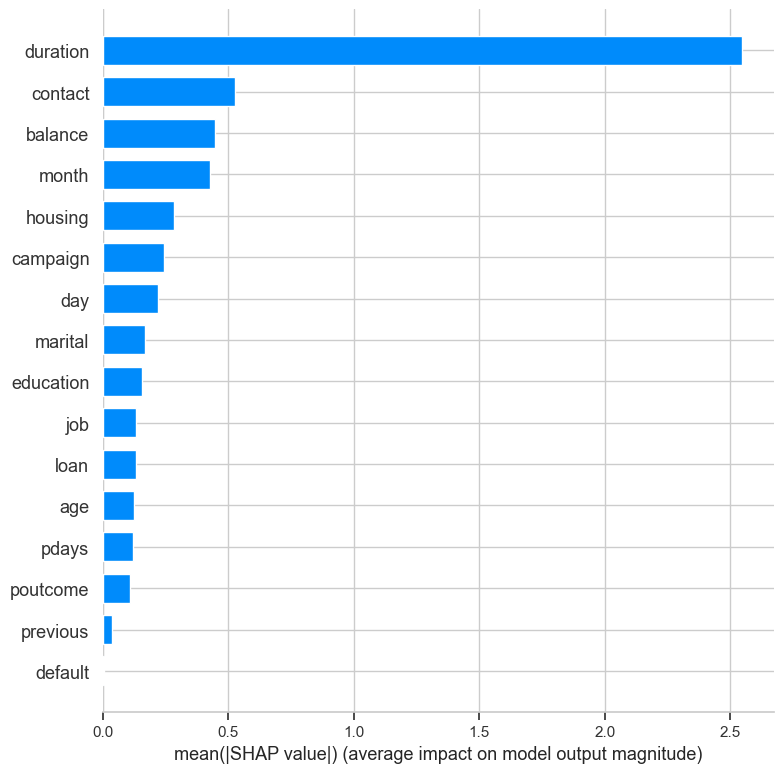

,feature,shap_value
11,duration,2.547109
8,contact,0.526777
5,balance,0.446364
10,month,0.425806
6,housing,0.284009
12,campaign,0.244179
9,day,0.220989
2,marital,0.169252
3,education,0.155955
1,job,0.132742


In [75]:
shap_values = visual.shap_values(cb_origin_model, data_train_origin)

shap_values